In [645]:
# Enable autoreload for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [646]:
# Setup
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [647]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [648]:
# Load and clean data
from src.load_data import load_data

In [649]:
df = load_data()
df

,No.,Diameter (mm),Speed (rpm),Feed (mm/rev),Thrust force (N),Torque (Nm),Flank wear (mm),Workpiece
0,1,9.0,500,0.13,1088.1,10.67,0.10,cast iron
1,2,9.0,500,0.18,1435.1,14.66,0.13,cast iron
2,3,9.0,500,0.25,1588.3,16.04,0.06,cast iron
3,4,9.0,500,0.36,1669.8,17.12,0.09,cast iron
4,5,9.0,400,0.13,1150.9,11.22,0.12,cast iron
...,...,...,...,...,...,...,...,...
160,161,10.0,1000,0.50,1960.0,18.13,0.13,copper
161,162,7.5,1000,0.50,784.0,7.35,0.10,copper
162,163,5.0,1000,0.50,651.0,6.17,0.07,copper
163,164,10.0,1000,0.71,2009.0,20.58,0.17,copper


In [650]:
from src.clean_data import clean_dataset, add_features
df_clean = clean_dataset(df)

In [651]:
# from src.outlier_handling import cap_outliers_iqr

# # Now this will work correctly
# df_clean = cap_outliers_iqr(df_clean, 'thrust_force_(n)', multiplier=1.0)


In [652]:
# print(f"Updated shape after outlier removal: {df_clean.shape}")


In [653]:
df_clean = add_features(df_clean)  # ⬅️ Feature Engineering : this includes new features

In [654]:
# Identify one-hot workpiece columns (e.g., 'workpiece_b', 'workpiece_c', etc.)
workpiece_cols = [col for col in df_clean.columns if col.startswith('workpiece_')]

In [655]:
# Confirm all required columns exist
print("Cleaned Columns:", df_clean.columns.tolist())

Cleaned Columns: ['no.', 'diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)', 'thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)', 'workpiece_copper', 'workpiece_mild steel', 'speed_per_dia', 'log_feed', 'torque_feed_ratio', 'material_hardness', 'feed_squared', 'speed_squared']


In [656]:
df_clean.shape

(164, 15)

In [657]:
# Features and targets
X = df_clean[['diameter_(mm)', 'speed_(rpm)', 'feed_(mm/rev)',
              'speed_per_dia', 'log_feed',
              'torque_feed_ratio', 'material_hardness',
              'feed_squared', 'speed_squared'] + workpiece_cols]
import numpy as np
# Target transformation: log-transform all 3 targets
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()

# Log-transform each to handle skewness and stabilize variance
for col in y.columns:
    y[col] = np.log1p(y[col])  # log1p avoids issues with zeros




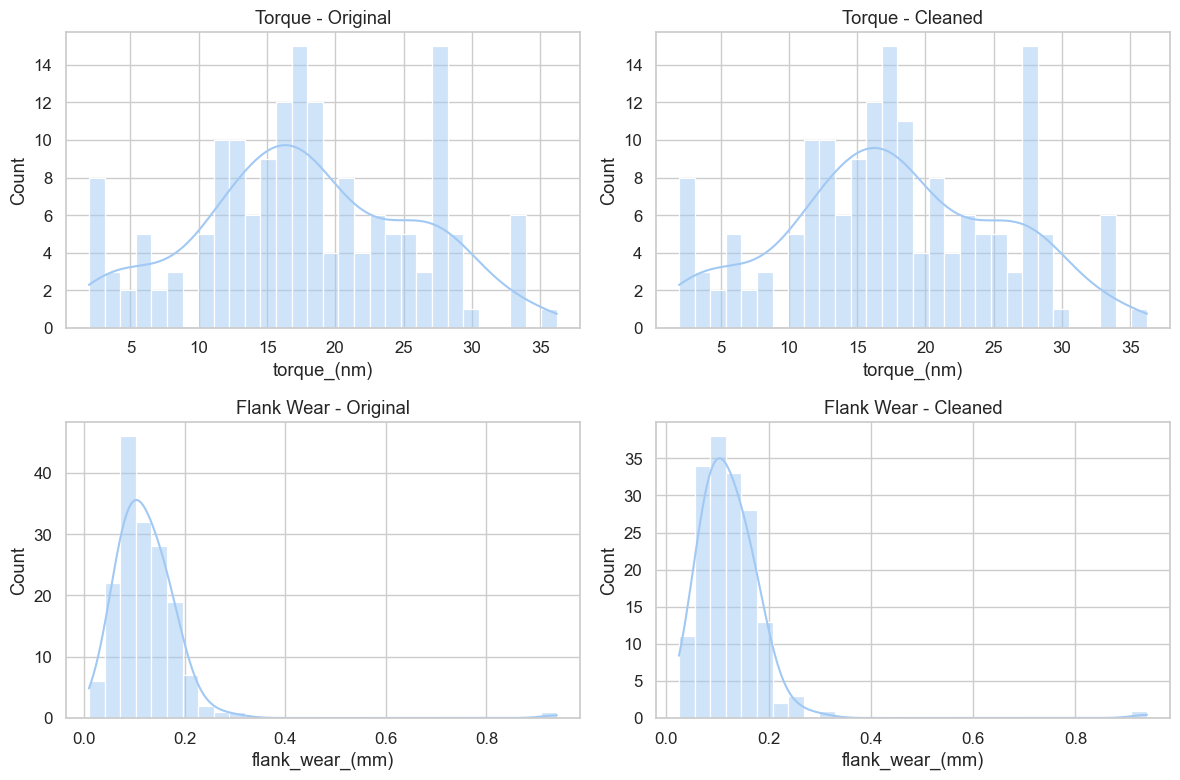

In [658]:
# Visualize distributions before and after cleaning
df_orig = load_data()
df_orig.columns = df_orig.columns.str.strip().str.lower().str.replace(' ', '_')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df_orig['torque_(nm)'], bins=30, ax=axs[0,0], kde=True)
axs[0,0].set_title("Torque - Original")

sns.histplot(df_clean['torque_(nm)'], bins=30, ax=axs[0,1], kde=True)
axs[0,1].set_title("Torque - Cleaned")

sns.histplot(df_orig['flank_wear_(mm)'], bins=30, ax=axs[1,0], kde=True)
axs[1,0].set_title("Flank Wear - Original")

sns.histplot(df_clean['flank_wear_(mm)'], bins=30, ax=axs[1,1], kde=True)
axs[1,1].set_title("Flank Wear - Cleaned")

plt.tight_layout()
plt.show()

Interpretation: (a)Torque values seem to follow a roughly normal distribution with no significant outliers.
(b)Flank wear had outliers or noise at the high end, which were removed during cleaning.

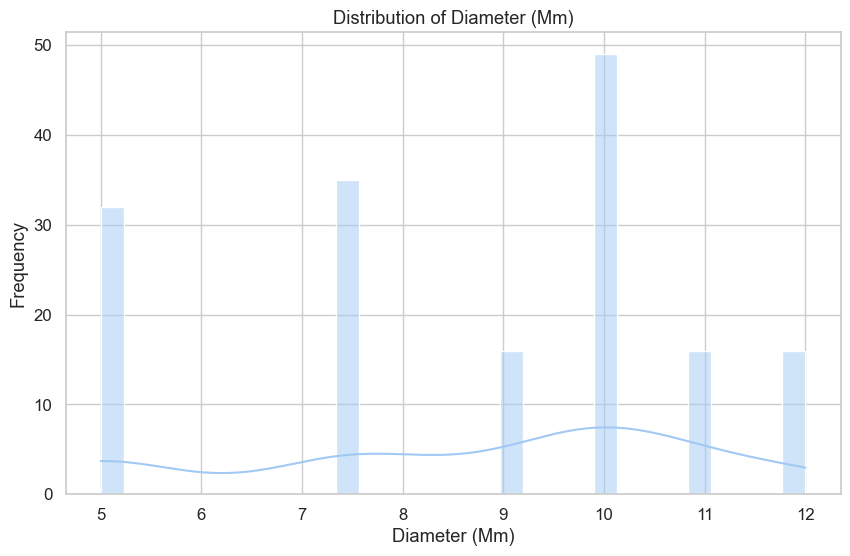

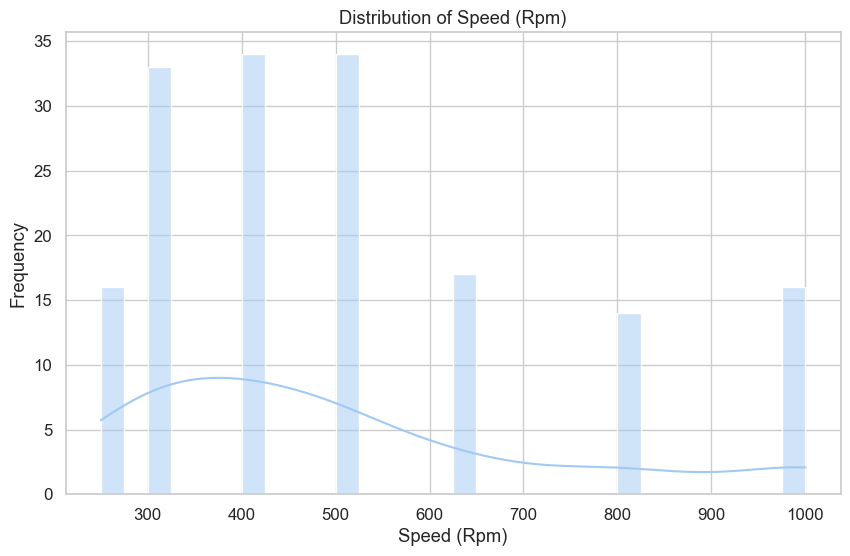

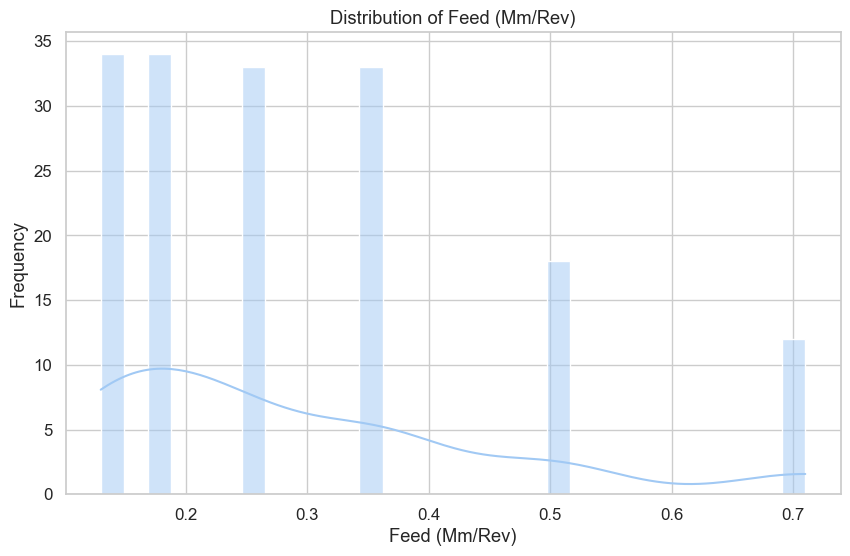

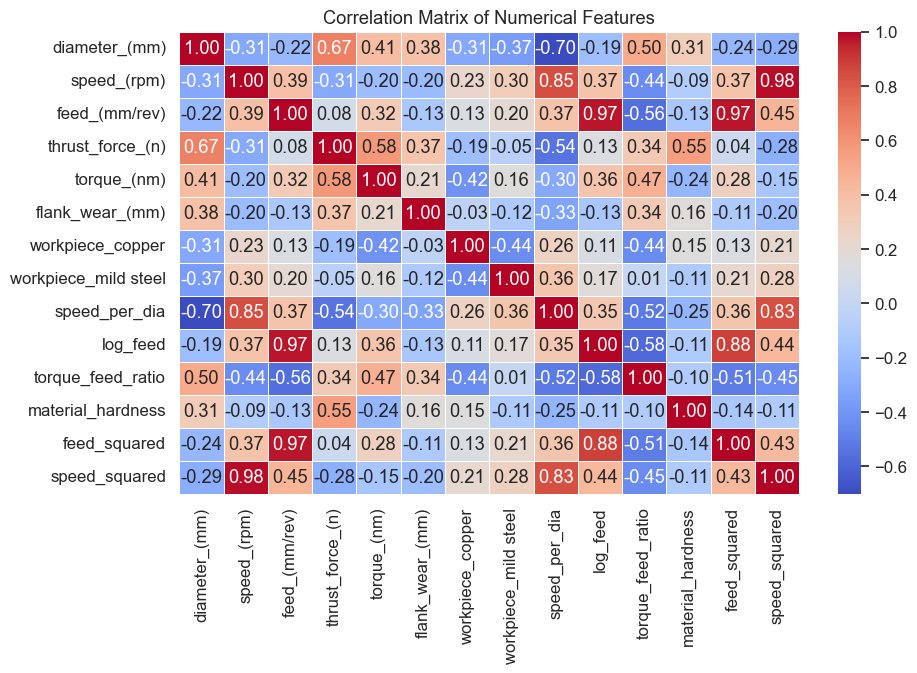

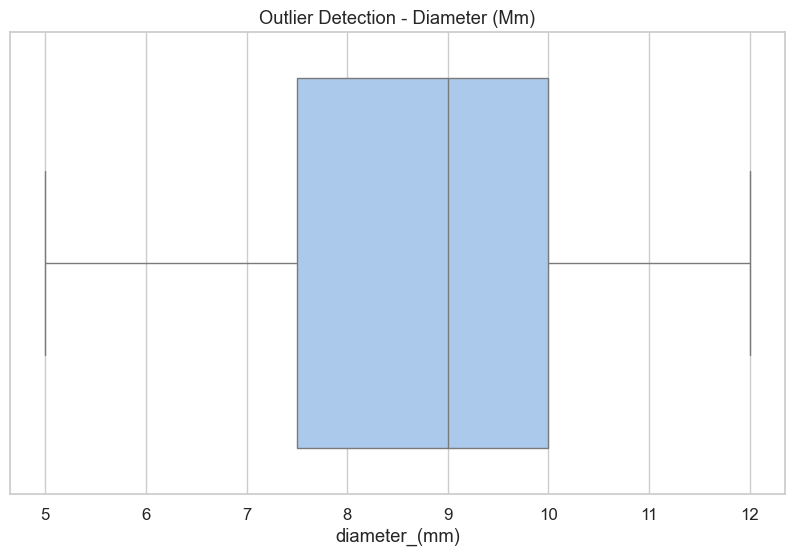

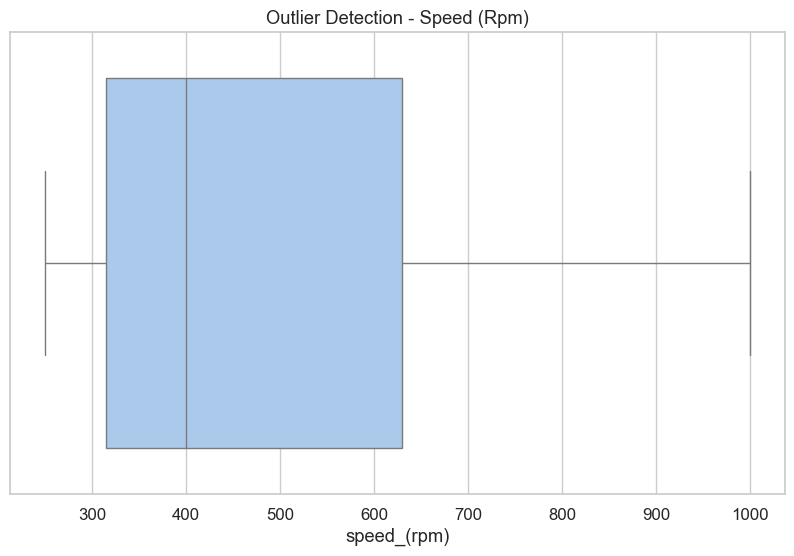

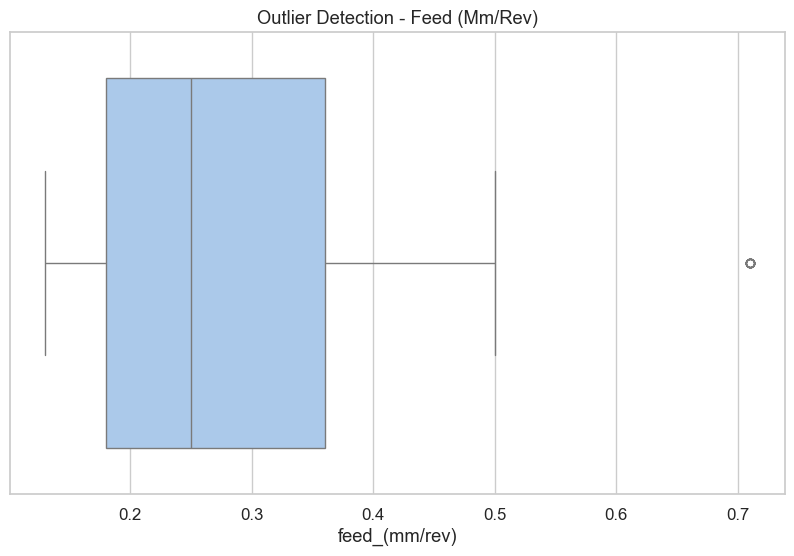

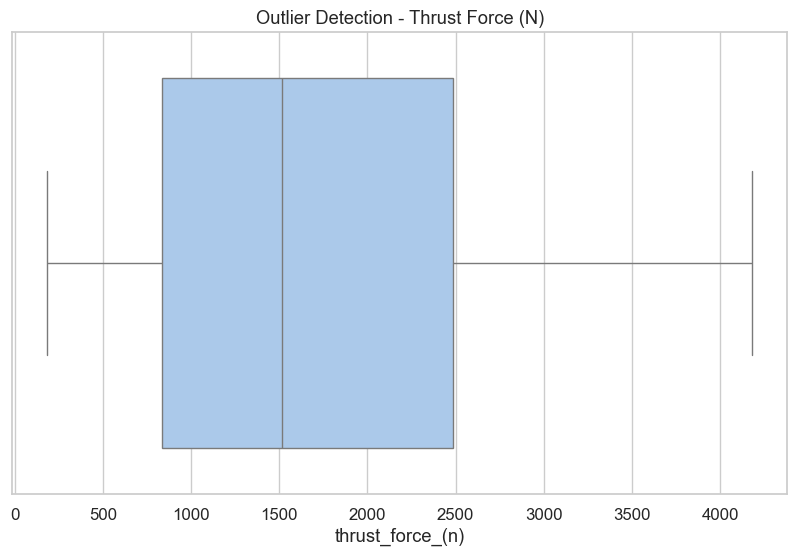

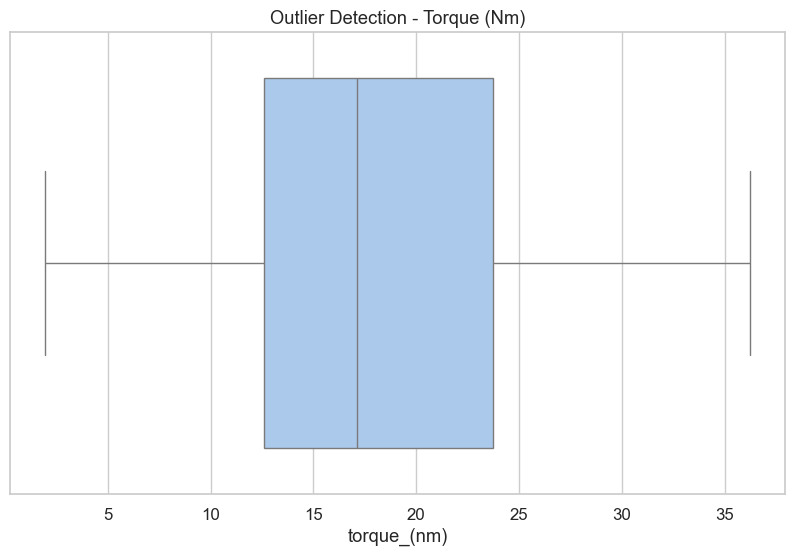

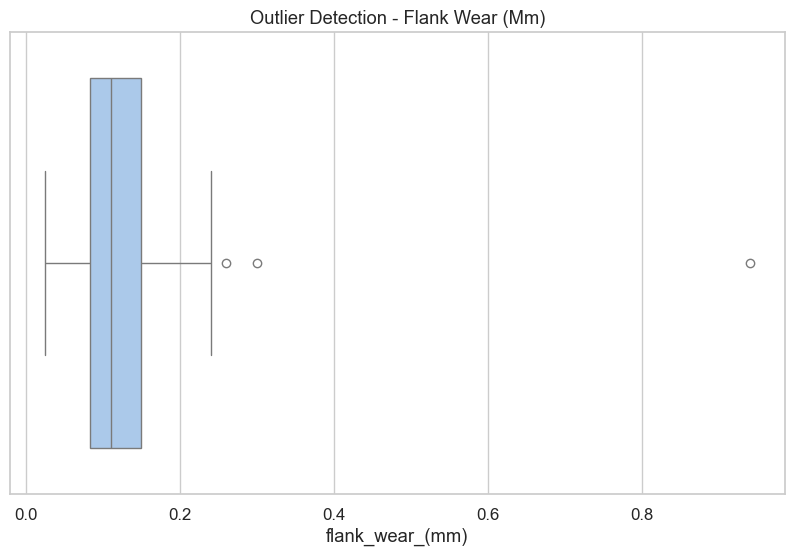

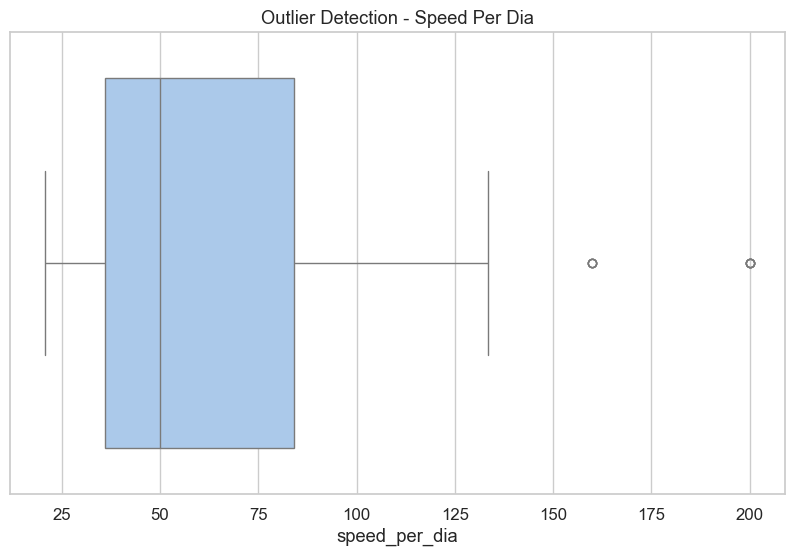

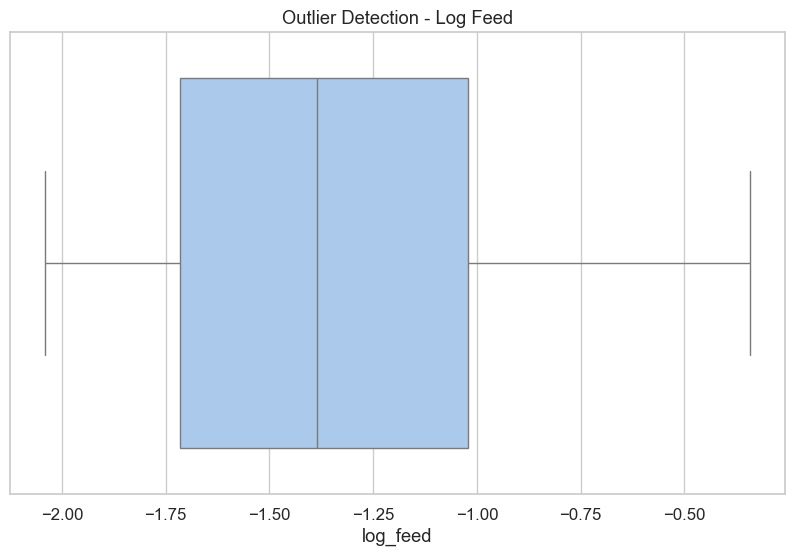

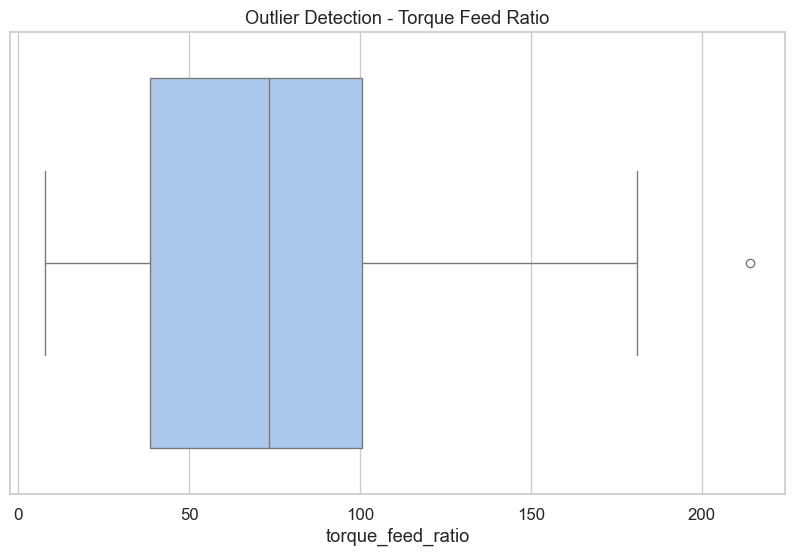

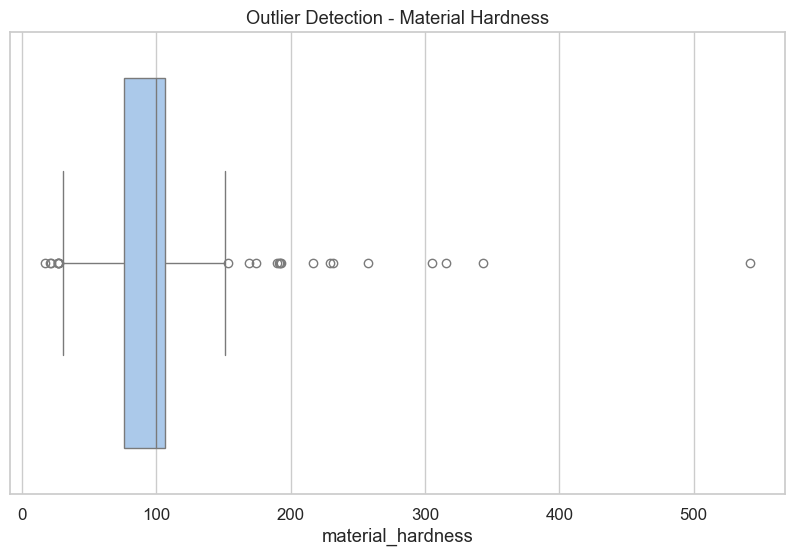

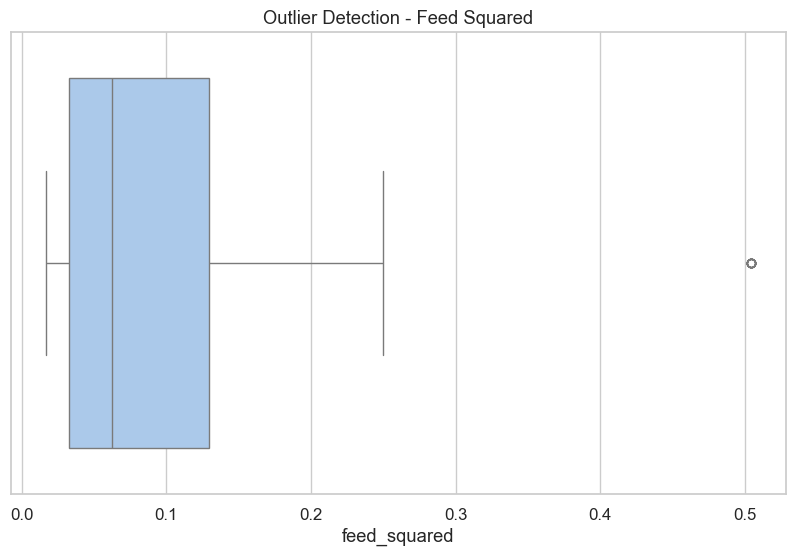

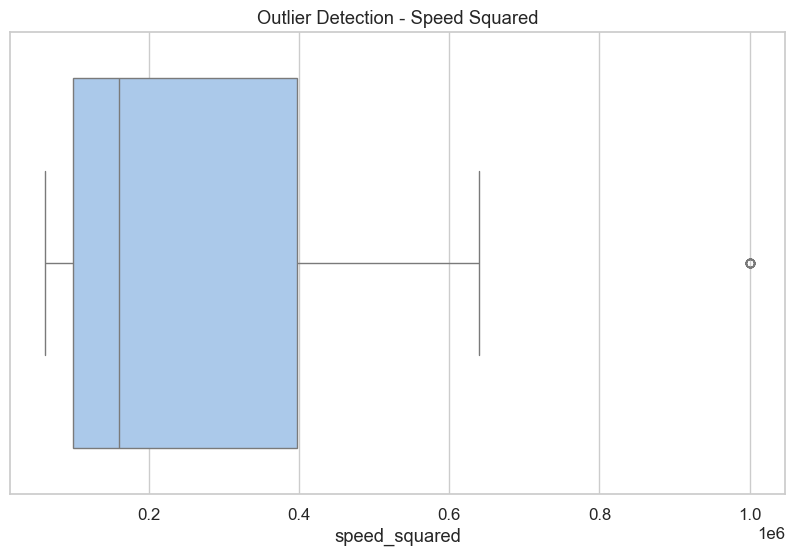

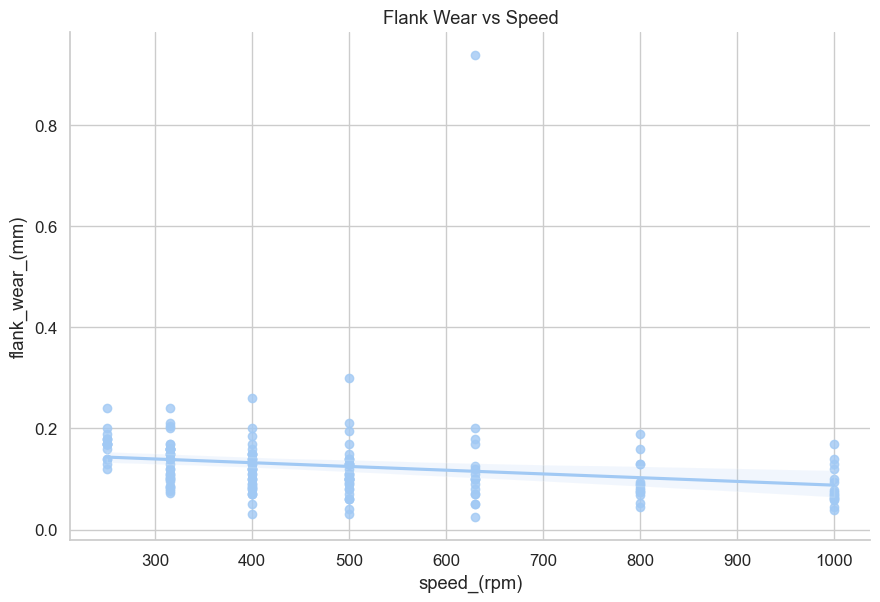

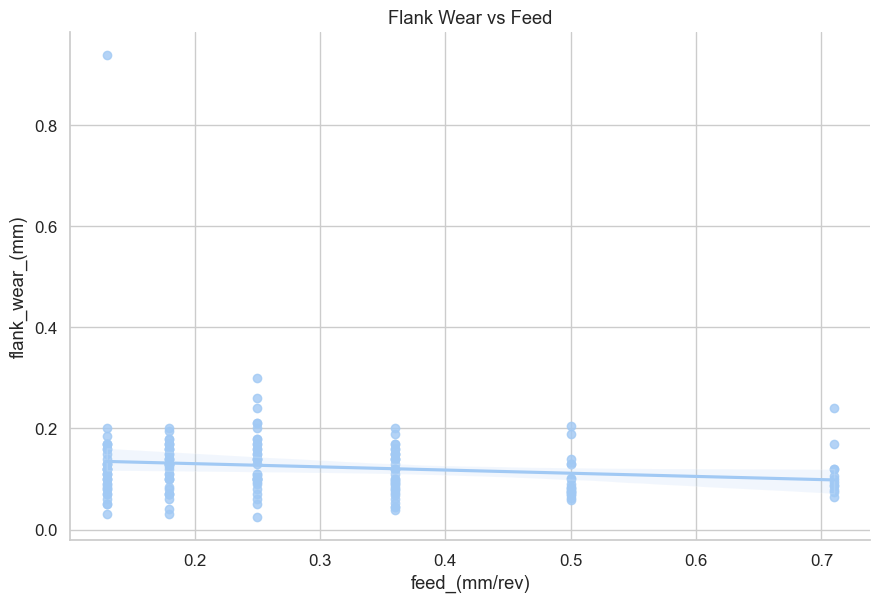

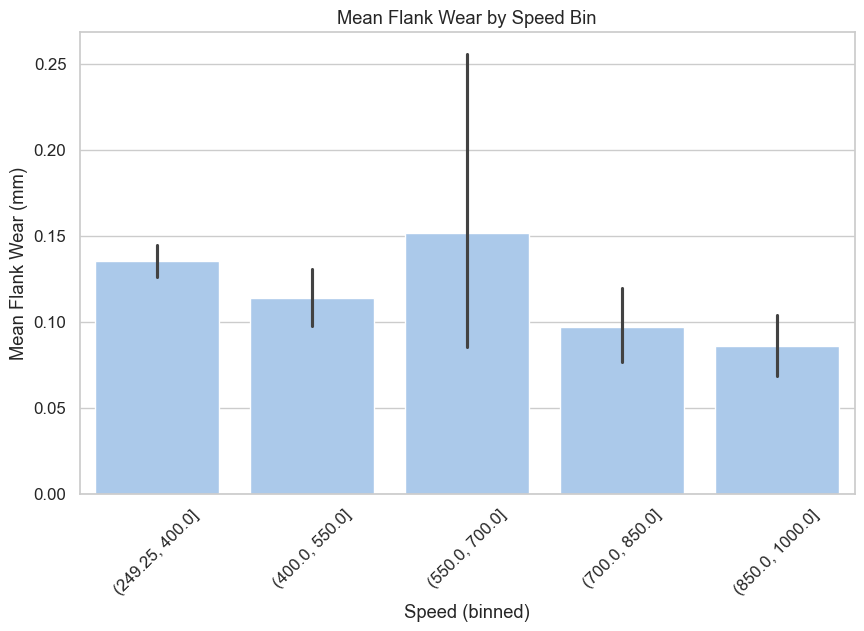

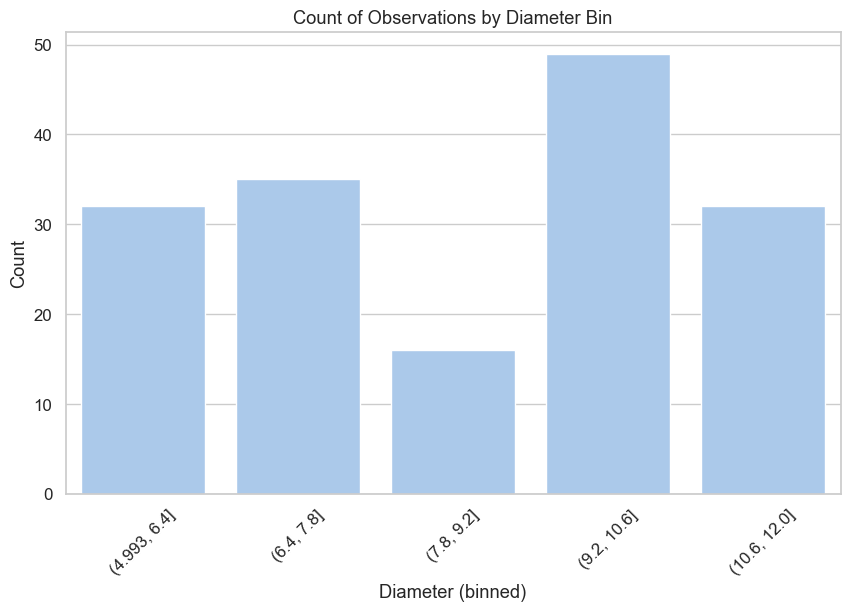

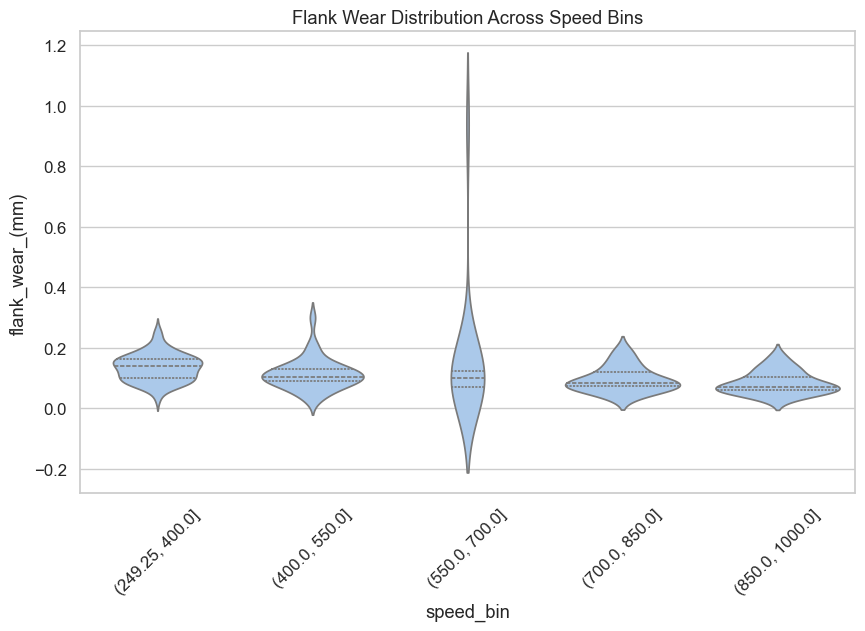

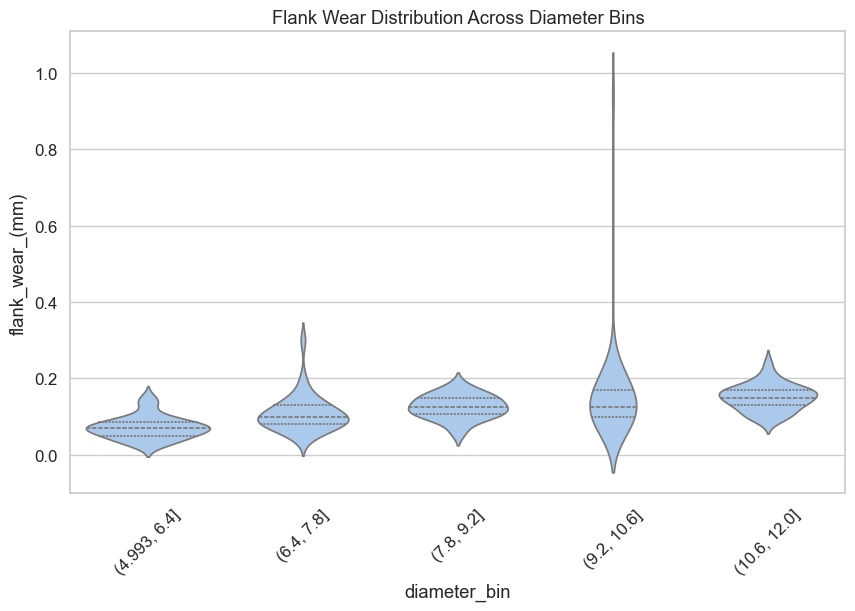

In [659]:
# General visualizations
from src.visualise_data import visualize
visualize(df_clean)

In [660]:
# Model tuning
from src.tune_models import tune_random_forest
best_rf, best_params, cv_results = tune_random_forest(X, y)
print("Best Params:", best_params)

import pandas as pd
cv_df = pd.DataFrame(cv_results)
cv_df = cv_df.sort_values(by='mean_test_score', ascending=False)
cv_df[['params', 'mean_test_score', 'rank_test_score']].head()

Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


,params,mean_test_score,rank_test_score
28,"{'max_depth': 10, 'max_features': 'log2', 'min...",0.018316,1
19,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.018316,1
0,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.015380,3
45,"{'max_depth': 20, 'max_features': 'log2', 'min...",0.015380,3
9,"{'max_depth': None, 'max_features': 'log2', 'm...",0.015380,3


In [661]:
# Model training and evaluation
from src.model_train import train_models
results = train_models(X, y)

In [662]:
# Model training and evaluation
from src.model_train import train_models

results = train_models(X, y)

# Extract test set and predictions (still log-scale here)
X_test = results['X_test']
y_test_log = results['y_test']      # ✅ rename for clarity
models = results['models']
metrics = results['metrics']

# ✅ Inverse transform log-scale targets for real-world evaluation
import numpy as np
y_test_orig = np.expm1(np.clip(y_test_log.values, 0, 20))


In [663]:
y = df_clean[['thrust_force_(n)', 'torque_(nm)', 'flank_wear_(mm)']].copy()
y_log = np.log1p(y)
results = train_models(X, y_log)


In [664]:
y_test_orig = np.expm1(np.clip(results['y_test'].values, 0, 20))
y_pred_orig = np.expm1(np.clip(models['RandomForest'].predict(X_test), 0, 20))


In [665]:
# This must come from the model training results
X_test = results['X_test']
y_test = results['y_test']  # <--- THIS is missing in your current cell
models = results['models']


🔍 Plotting for: RandomForest


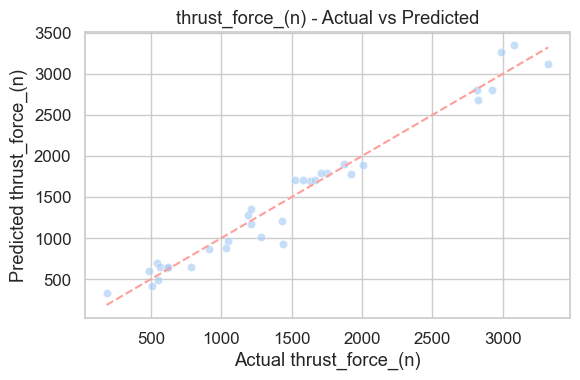

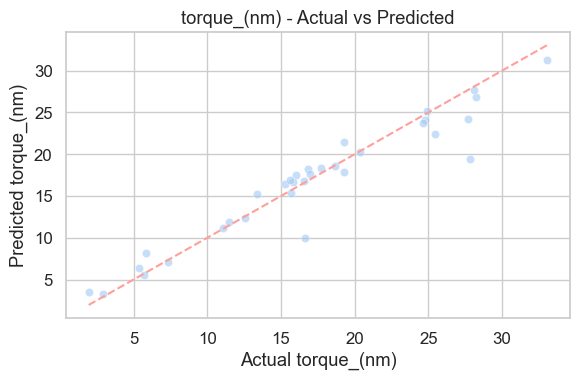

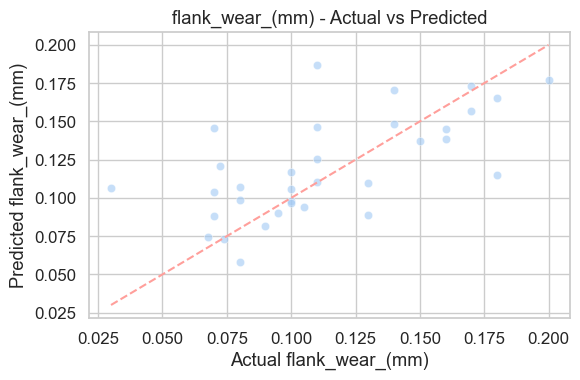

🔍 Plotting for: XGBoost


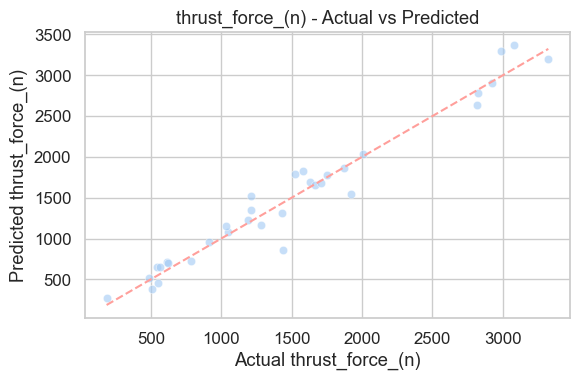

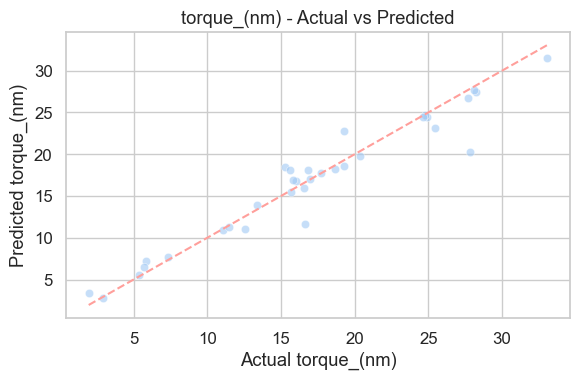

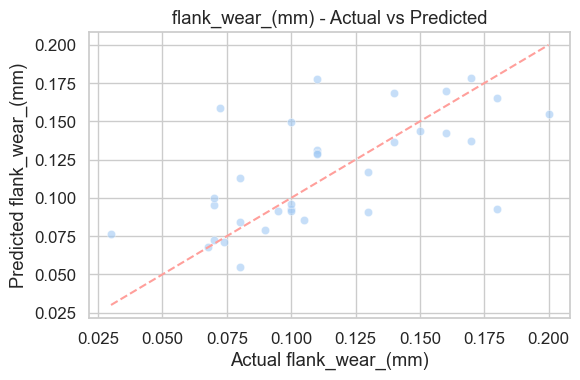

🔍 Plotting for: KNN


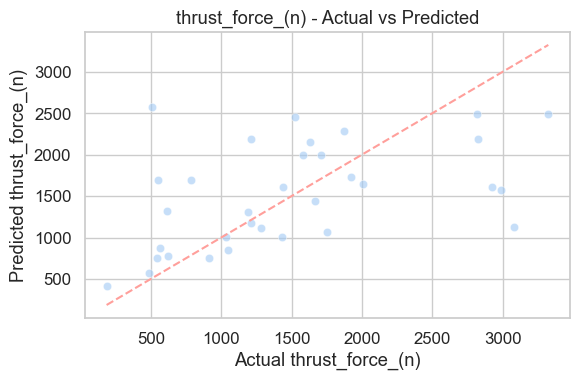

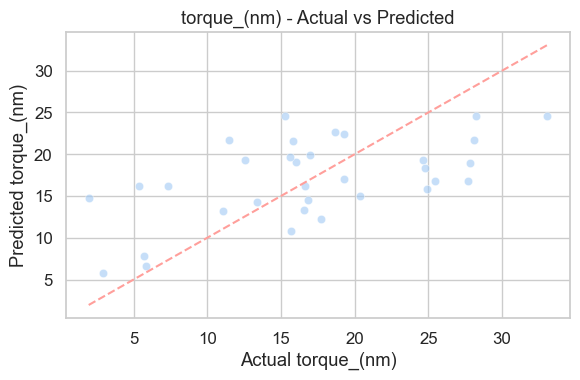

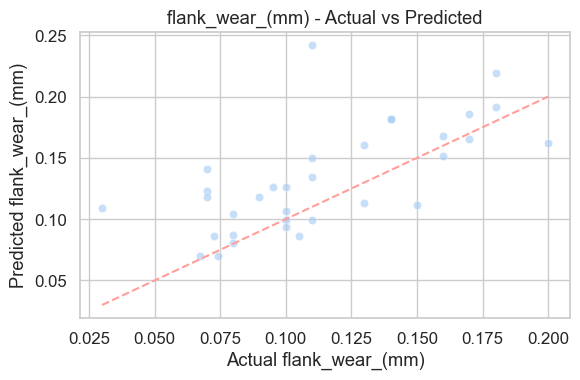

In [666]:
from src.evaluate_models import plot_predictions
import numpy as np

for model_name in models:
    print(f"🔍 Plotting for: {model_name}")

    # Predict in log-space
    y_pred_log = models[model_name].predict(X_test)

    # Inverse transform both prediction and ground truth
    y_pred_orig = np.expm1(np.clip(y_pred_log, 0, 20))
    y_test_orig = np.expm1(np.clip(y_test.values, 0, 20))

    # Plot on original scale
    plot_predictions(y_test_orig, y_pred_orig, y.columns)


In [667]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np

# for model_name in models:
#     print(f"\n📌 {model_name} Metrics (Original Scale):")

#     # Predict in log-scale
#     y_pred_log = models[model_name].predict(X_test)

#     # Inverse-transform both prediction and test targets
#     y_pred_orig = np.expm1(np.clip(y_pred_log, 0, 20))
#     y_test_orig = np.expm1(np.clip(y_test.values, 0, 20))

#     # Compute metrics for each target
#     for i, target in enumerate(y.columns):
#         y_true = y_test_orig[:, i]
#         y_pred = y_pred_orig[:, i]

#         r = np.corrcoef(y_true, y_pred)[0, 1]
#         r2 = r2_score(y_true, y_pred)
#         mae = mean_absolute_error(y_true, y_pred)
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-5))) * 100

#         print(f"  R     for {target}: {r:.4f}")
#         print(f"  R2    for {target}: {r2:.4f}")
#         print(f"  MAE   for {target}: {mae:.4f}")
#         print(f"  MSE   for {target}: {mse:.4f}")
#         print(f"  RMSE  for {target}: {rmse:.4f}")
#         print(f"  MAPE  for {target}: {mape:.2f}%")

#     print("-" * 40)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make sure these are defined:
X_test = results['X_test']
y_test = results['y_test']
models = results['models']

for model_name in models:
    print(f"\n📌 {model_name} Metrics (Original Scale):")

    # Predict in log-scale
    y_pred_log = models[model_name].predict(X_test)

    # Inverse-transform both prediction and test targets
    y_pred_orig = np.expm1(np.clip(y_pred_log, 0, 20))
    y_test_orig = np.expm1(np.clip(y_test.values, 0, 20))

    # Compute metrics for each target
    for i, target in enumerate(y.columns):
        y_true = y_test_orig[:, i]
        y_pred = y_pred_orig[:, i]

        r = np.corrcoef(y_true, y_pred)[0, 1]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-5))) * 100

        print(f"  R     for {target}: {r:.4f}")
        print(f"  R2    for {target}: {r2:.4f}")
        print(f"  MAE   for {target}: {mae:.4f}")
        print(f"  MSE   for {target}: {mse:.4f}")
        print(f"  RMSE  for {target}: {rmse:.4f}")
        print(f"  MAPE  for {target}: {mape:.2f}%")

    print("-" * 40)




📌 RandomForest Metrics (Original Scale):
  R     for thrust_force_(n): 0.9820
  R2    for thrust_force_(n): 0.9630
  MAE   for thrust_force_(n): 129.4561
  MSE   for thrust_force_(n): 26735.0005
  RMSE  for thrust_force_(n): 163.5084
  MAPE  for thrust_force_(n): 12.24%
  R     for torque_(nm): 0.9600
  R2    for torque_(nm): 0.9153
  MAE   for torque_(nm): 1.4237
  MSE   for torque_(nm): 5.2034
  RMSE  for torque_(nm): 2.2811
  MAPE  for torque_(nm): 10.81%
  R     for flank_wear_(mm): 0.6457
  R2    for flank_wear_(mm): 0.3608
  MAE   for flank_wear_(mm): 0.0236
  MSE   for flank_wear_(mm): 0.0010
  RMSE  for flank_wear_(mm): 0.0322
  MAPE  for flank_wear_(mm): 28.58%
----------------------------------------

📌 XGBoost Metrics (Original Scale):
  R     for thrust_force_(n): 0.9779
  R2    for thrust_force_(n): 0.9543
  MAE   for thrust_force_(n): 130.2311
  MSE   for thrust_force_(n): 33012.0763
  RMSE  for thrust_force_(n): 181.6923
  MAPE  for thrust_force_(n): 11.41%
  R     for 

In [668]:
import pandas as pd

rows = []

for model_name, model_metrics in metrics.items():
    for i, target in enumerate(y.columns):
        row = {
            'Model': model_name,
            'Target': target,
            'R': model_metrics.get('R', [None]*len(y.columns))[i],
            'R2': model_metrics.get('R2', [None]*len(y.columns))[i],
            'MAE': model_metrics.get('MAE', [None]*len(y.columns))[i],
            'MSE': model_metrics.get('MSE', [None]*len(y.columns))[i],
            'RMSE': model_metrics.get('RMSE', [None]*len(y.columns))[i]
        }
        rows.append(row)

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values(by='Target'))


,Model,Target,R,R2,MAE,MSE,RMSE
2,RandomForest,flank_wear_(mm),0.645704,0.360754,0.023613,0.001035,0.032172
5,XGBoost,flank_wear_(mm),0.633095,0.329882,0.024038,0.001085,0.032939
8,KNN,flank_wear_(mm),0.669224,0.074072,0.027925,0.001499,0.038719
0,RandomForest,thrust_force_(n),0.981994,0.962989,129.456121,26735.000456,163.508411
3,XGBoost,thrust_force_(n),0.977862,0.954300,130.231057,33012.076320,181.692257
6,KNN,thrust_force_(n),0.489941,0.187065,563.789066,587230.697187,766.309792
1,RandomForest,torque_(nm),0.960042,0.915345,1.423712,5.203447,2.281106
4,XGBoost,torque_(nm),0.968206,0.935264,1.229041,3.979107,1.994770
7,KNN,torque_(nm),0.575624,0.329752,5.516239,41.197778,6.418550


Use the following code to explicitly train model for Flankwear

In [669]:
from src.train_flankwear import train_flankwear_model

# Call custom function with engineered features and original wear target
fw_result = train_flankwear_model(X, df_clean['flank_wear_(mm)'])

print("📌 Best Parameters:", fw_result['params'])
print("📈 Metrics for Flank Wear (Original Scale, Separate Model):")
for k, v in fw_result['metrics'].items():
    print(f"{k}: {v:.4f}")



📌 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
📈 Metrics for Flank Wear (Original Scale, Separate Model):
R2: 0.3801
MAE: 0.0243
MSE: 0.0010
RMSE: 0.0317


In [670]:
# from src.knn_model import train_knn_model

# knn_results = train_knn_model(X, y)

# print("📊 KNN Metrics for Each Target:")
# for name, values in zip(y.columns, zip(*knn_results['metrics'].values())):
#     print(f"\n{name}")
#     print(f"R2: {values[0]:.4f}")
#     print(f"MAE: {values[1]:.4f}")
#     print(f"MSE: {values[2]:.4f}")
#     print(f"RMSE: {values[3]:.4f}")
#     print(f"MAPE: {values[4]:.2f}%")

from src.knn_model import train_knn_model

knn_results = train_knn_model(X, y)

print("📊 KNN Metrics for Each Target:")

# Extract metric names and values
metric_keys = list(knn_results['metrics'].keys())  # ['R', 'R2', 'MAE', 'MSE', 'RMSE', 'MAPE']
metric_values = list(knn_results['metrics'].values())  # Each is a NumPy array

# Transpose the values to group by target
for idx, target_name in enumerate(y.columns):
    print(f"\n{target_name}")
    for key, values in zip(metric_keys, metric_values):
        if isinstance(values, (list, tuple, np.ndarray)):
            print(f"{key}: {values[idx]:.4f}" if key != "MAPE" else f"{key}: {values[idx]:.2f}%")


📊 KNN Metrics for Each Target:

thrust_force_(n)
R: 1.0000
R2: 1.0000
MAE: 0.0000
MSE: 0.0000
RMSE: 0.0000
MAPE: 0.00%

torque_(nm)
R: 0.4792
R2: -0.0359
MAE: 130483071.9015
MSE: 50091618771281920.0000
RMSE: 223811569.7887
MAPE: 21515954.14%

flank_wear_(mm)
R: 0.1288
R2: 0.0134
MAE: 0.0654
MSE: 0.0431
RMSE: 0.2075
MAPE: 55.68%
